# Step 3 - Climate Analysis and Exploration

In [27]:
# import dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import pandas as pd
import datetime as dt
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
from sqlalchemy import and_
import seaborn as sns

In [28]:
#Create engine using hawaii.sqlite database file
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [29]:
#Declare a base
Base = automap_base()

In [30]:
#Use the base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [31]:
Base.classes.keys()

['measurements', 'stations']

In [32]:
# save a reference to those classes
Station = Base.classes.stations
Measurement = Base.classes.measurements

In [33]:
# create a session
session = Session(engine)

In [34]:
#latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#prcp_date = session.query(Measurement.date,func.sum(Measurement.prcp).label('total_prcp')).\
#                                group_by(func.strftime("%Y-%m", Measurement.date)).\
#                                   filter(Measurement.date < 'latest_date').\
 #                                   order_by(Measurement.date.desc()).\
 #                                   limit(12).all()

# Precipitation Analysis

In [35]:
# Get the last 12months
year_ago = dt.date.today() - dt.timedelta(days=365)

In [36]:
# Get the precipitation values from last 12months
prcp = session.query(Measurement.date, Measurement.prcp).\
                                   filter(Measurement.date >= year_ago).\
                                    order_by(Measurement.date.desc()).all()

In [37]:
#Create a dataframe with last 12months prcp values and set the DF index to date
prcp_df = pd.DataFrame(prcp, columns=['date','precipitation'])
prcp_df.set_index('date', inplace=True)

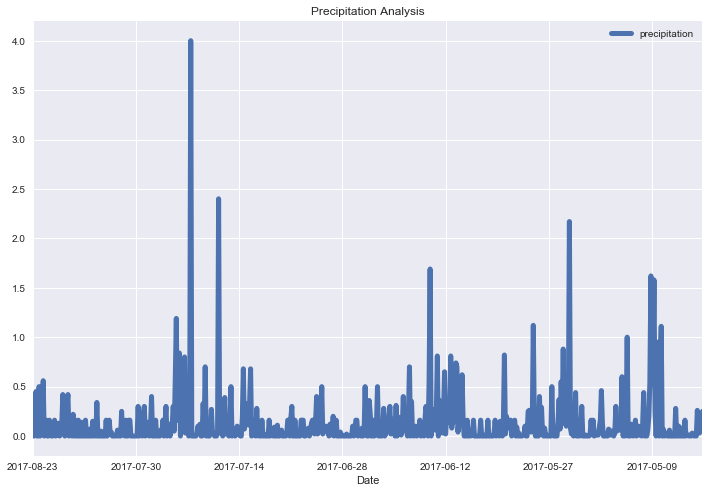

In [38]:
# plot the precipitation data for last 12months
sns.set()
prcp_df.plot(use_index=True, figsize = (12,8), grid=True, title = 'Precipitation Analysis', kind = 'line',linewidth = 5)
plt.xlabel('Date')
plt.show()


In [39]:
#Get the statistics for precipitation data
prcp_df.describe()

,precipitation
count,650.000000
mean,0.128501
std,0.284220
min,0.000000
25%,0.000000
50%,0.030000
75%,0.160644
max,4.000000


# Station Analysis

In [40]:
# Get the total number of unique stations
session.query(Station.station).count()

9

In [41]:
# list the stations and observation counts in descending order
session.query(Measurement.station, func.count(Measurement.station).label('Total_observation')).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
#Which station has the highest number of observations?
best_station = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
best_station

('USC00519281')

In [43]:
#Get the last 12 months of temperature observation data (tobs) by filtering on the best station
tobs = session.query(Measurement.tobs).\
                                filter(and_(Measurement.date > year_ago, Measurement.station == best_station.station)).all()

In [44]:
tobs_df = pd.DataFrame(tobs)

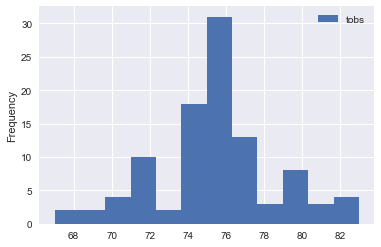

In [45]:
#Plot the results as a histogram with bins=12
tobs_df.plot.hist(bins=12)
plt.show()

# Temperature Analysis

In [46]:
# a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, 
#and maximum temperatures for that range of dates.
def calc_temps(start_date, end_date):
    
    
    return session.query(func.avg(Measurement.tobs), func.min(Measurement.tobs), func.max(Measurement.tobs)).\
                                                 filter(and_(Measurement.date<= end_date, Measurement.date>=start_date)).all()
print(calc_temps('2017-04-23', '2017-04-30'))

[(73.1, 58, 81)]


In [47]:
start_date = '2017-04-23'
end_date = '2017-04-30'
avg_temp, tmin, tmax = calc_temps(start_date, end_date)[0]
print(avg_temp, tmin, tmax)

73.1 58 81


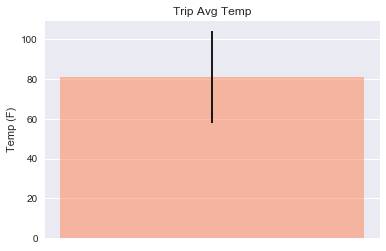

In [48]:
#Plot the min, avg, and max temperature from your previous query as a bar chart.
xpos = 1
yerr = tmax-tmin

plt.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center", tick_label="a")
plt.xticks(range(xpos))
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.show()

# Optional Recommended Analysis

In [49]:
#Create a function called daily_normals that will calculate the daily normals for a specific date. 
#This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.
def daily_normals(date):
    
    sel = [func.avg(Measurement.tobs), func.min(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("04-26")

[(74.01724137931035, 66, 81)]

Optional Recommended Analysis

In [50]:
# Create a list of dates for your trip in the format %m-%d. 
#Use the daily_normals function to calculate the normals for each date string and append the results to a list.
start_date = "2018-05-01"
end_date = "2018-05-07"

dates = pd.date_range(start_date, end_date, freq="D")
date_month_day = dates.strftime("%m-%d")

normals_list = []

for date in date_month_day:
    normals_list.append(*daily_normals(date))
normals_list

[(72.75925925925925, 65, 79),
 (73.05084745762711, 65, 79),
 (73.41071428571429, 67, 84),
 (73.59649122807018, 65, 78),
 (73.39655172413794, 67, 79),
 (73.14035087719299, 66, 80),
 (71.78846153846153, 64, 79)]

In [51]:
df = pd.DataFrame(normals_list, columns=['tavg','tmin', 'tmax'])
df ['date'] = dates
df.set_index(['date'], inplace=True)
df.head()

,tavg,tmin,tmax
date,,,
2018-05-01,72.759259,65,79
2018-05-02,73.050847,65,79
2018-05-03,73.410714,67,84
2018-05-04,73.596491,65,78
2018-05-05,73.396552,67,79


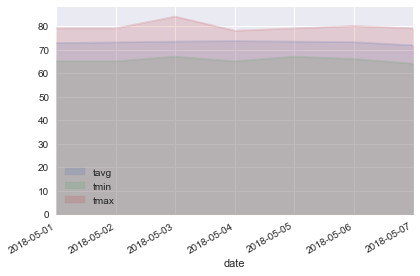

In [52]:
#  plot an area plot (stacked=False) for the daily normals
df.plot(kind='area', stacked=False, x_compat=True, alpha=0.2)
plt.tight_layout()
plt.show()

In [54]:
tobs_df.dtypes

tobs    int64
dtype: object